<a href="https://colab.research.google.com/github/jocelynzhao3/hello-world/blob/main/Jocelyn_Zhao_Fashion_MNIST_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fashion MNIST Final Project
1. Write code [done]
2. Change aspects until most effective

Import libraries

In [ ]:
import math
import numpy as np

import torch
from torch import nn, optim, cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

### how to use GPU on mac???
use_gpu=True
if cuda.is_available():
    # check if GPU is available
    print(cuda.get_device_properties(0))

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline

Download dataset

In [ ]:
####### preparing transforming functions - how do these affect results?
# data_tf=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
data_tf=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# download datasets
train_dataset = datasets.FashionMNIST(root='...', train=True, transform=data_tf, download=True)
test_dataset = datasets.FashionMNIST(root='...', train=False, transform=data_tf, download=True)
#does anything go in the root string? - just download and dont worry abt it



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting .../FashionMNIST/raw/train-images-idx3-ubyte.gz to .../FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting .../FashionMNIST/raw/train-labels-idx1-ubyte.gz to .../FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting .../FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .../FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting .../FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .../FashionMNIST/raw



Load datasets

In [ ]:
# data loader
batch_size=64
#######how does batch size affect result? power of 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Display sample pictures from the dataset

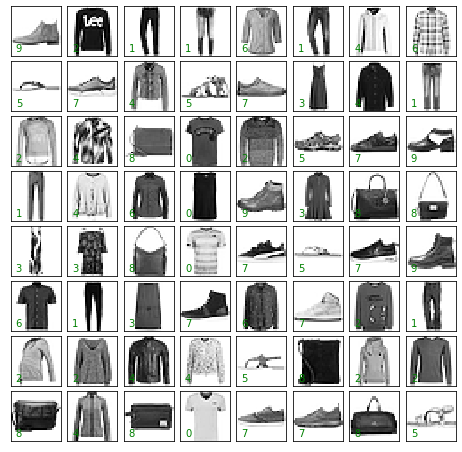

In [ ]:
sample_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
data=iter(sample_loader)
samples,sample_labels=data.next()

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)


fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, sample_labels[i].numpy(), transform=ax.transAxes, color='green')

Define a deep neural network

In [ ]:
class CNNExample(nn.Module):
    """
    from: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
    """
    def __init__(self):
        super(CNNExample, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (grayscale image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x) # conv layer 1
        x = F.relu(x) # activation function
        x = self.conv2(x) # conv layer 2
        x = F.max_pool2d(x, 2) # pool layer
        x = self.dropout1(x) # dropout layer 1
        x = torch.flatten(x, 1) # flatten layer 
        x = self.fc1(x) # full connection layer 1
        x = F.relu(x) # activation function
        x = self.dropout2(x) # dropout layer 2
        x = self.fc2(x) # full connection layer 2
        output = F.log_softmax(x, dim=1) # output use softmax function
        return output

Train the model

In [ ]:
##########training############
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss=0
        for data in train_loader:
            img, label = data
            #img = img.view(img.size(0),-1)
            if use_gpu and cuda.is_available(): #if use_gpu switch is on
                img=Variable(img).cuda()
                label=Variable(label).cuda()
            else:
                img=Variable(img)
                label=Variable(label)
            ##forward training
            out = model(img)
            loss = criterion(out, label)
            #loss=F.nll_loss(out,label)
            train_loss += loss.data*label.size(0)
            #print(loss.data)
            #print(label.size(0))
            train_loss+=loss.item()
            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()
        if (epoch+1)%(num_epochs/10) ==0:
            print(f'Epoch {epoch+1}/{num_epochs}, eval_loss={train_loss/(len(test_dataset))}')
    return model


Test the model

In [ ]:
##########testing##########
def test_model(model, criterion, test_loader):
    eval_loss=0
    eval_acc=0
    #use evaluation model
    model.eval()
    for data in test_loader:
        img, label = data
        #img = img.view(img.size(0),-1)
        if use_gpu and cuda.is_available(): #if use_gpu switch is on
            img=Variable(img).cuda()
            label=Variable(label).cuda()
        else:
            img=Variable(img)
            label=Variable(label)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.data*label.size(0)
        _, pred = torch.max(out, 1) #???
        num_correct = (pred==label).sum()
        eval_acc += num_correct.data
        #print('pred: {}, label: {}, num_correct: {}'.format(pred, label, num_correct))
    loss=eval_loss/(len(test_dataset))
    accuracy=eval_acc*1.0/(len(test_dataset))
    print(f'Test Loss: {loss}, Acc: {accuracy}')
    return loss, accuracy


Put together

In [ ]:
%%time

#gpu switch on/off
use_gpu=False

# # define model
# model=CNN()
model=CNNExample()
# model = CNN2()
# print(model)

if use_gpu and cuda.is_available():
    print(f'using GPU: {cuda.get_device_properties(0)}')
    model=model.cuda()
else:
    print('using CPU')
    model=model.cpu()
    
# learning rate
learning_rate=0.1
#learning_rate=1
    
#---optimizer for training the neural network---
# use Adadelta optimizer: https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html
optimizer=optim.Adadelta(model.parameters(), lr=learning_rate)
##---uncomment the following lines to try out different optimizers---
#optimizer=optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer=optim.Adam(model.parameters(), lr=learning_rate)
#optimizer=optim.SGD(model.parameters(), lr=learning_rate)


#---criterion is the cost or error function---
criterion=nn.CrossEntropyLoss()
#criterion=nn.NLLLoss()

# #---scheduler---
#scheduler = StepLR(optimizer, step_size=1, gamma=0.7) # need by NLLLoss

# set number of epochs
num_epochs=30

# train model
model = train_model(model, train_loader, criterion, optimizer, num_epochs)
loss, accuracy=test_model(model, criterion, test_loader)


using CPU


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 3/30, eval_loss=2.0973846912384033
Epoch 6/30, eval_loss=1.6712979078292847
Epoch 9/30, eval_loss=1.4332948923110962
Epoch 12/30, eval_loss=1.2469563484191895
Epoch 15/30, eval_loss=1.0995290279388428
Epoch 18/30, eval_loss=0.9787993431091309
Epoch 21/30, eval_loss=0.8772703409194946
Epoch 24/30, eval_loss=0.7843967080116272
Epoch 27/30, eval_loss=0.7292202711105347
Epoch 30/30, eval_loss=0.6654070019721985
Test Loss: 0.25037023425102234, Acc: 0.9262999892234802
CPU times: user 1h 13min 27s, sys: 53.3 s, total: 1h 14min 20s
Wall time: 1h 14min 5s


Make prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Predition Errors: 6 of 64 | Prediction accuracy: 90.625%


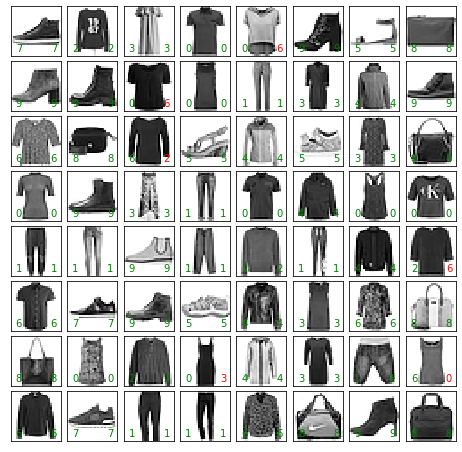

In [ ]:
sample_size=batch_size
# let shuffle be True to load random images each time
sample_loader = DataLoader(test_dataset, batch_size=sample_size, shuffle=True) 
data=iter(sample_loader)
samples,sample_labels=data.next()

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)

# output = model(samples.view(samples.size(0),-1))
output=model(samples)
_, pred = torch.max(output, 1)

# print(sample_labels)
# print(pred)

fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

error = 0 # prediction error
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, sample_labels[i].numpy(), transform=ax.transAxes, color='green')
    if sample_labels[i].numpy()==pred[i].numpy():
        color_pred='green'
    else:
        color_pred='red'
        error+=1
    ax.text(0.8, 0.1, pred[i].numpy(), transform=ax.transAxes, color=color_pred)

accuracy_predict=(1-error*1.0/sample_size)*100
print(f'Predition Errors: {error} of {sample_size} | Prediction accuracy: {accuracy_predict}%')
